In [289]:
import logging
import threading
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline

2019-10-01T17:19:09.970 DEBUG matplotlib.pyplot.switch_backend Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
credentials = {
  "tenantId": "AnalyticsServiceDev",
  "as_api_host": "https://api-dev.connectedproducts.internetofthings.ibmcloud.com",
  "as_api_key": "a-69xgm4-8bdgtvnsv4",
  "as_api_token": "9X_tMKdupOiJ!mzaPV",
  "config" : {
      "objectStorageEndpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net",
      "bos_runtime_bucket" : "analytics-runtime-analyticsservicedev-799d2008b460",
      "bos_logs_bucket" : "analytics-logs-analyticsservicedev-32703c52ec8b"
  },
  "objectStorage": {
      "username" : "58ddd86b5de8468b819d385046f17033",
      "password" : "ee0d6c5521ce9ff100f91b0e37d4eb8cc1a038b5a6d05b38",
      "region" : "us",
      "endpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net"
  },
  "db2": {
    "username": "bluadmin",
    "password": "ZmM5MmE5NmZkZGZl",
    "databaseName": "BLUDB",
    "port": 50000,
    "httpsUrl": "https://dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000",
    "host": "dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net"
  }
}
EngineLogging.configure_console_logging(logging.DEBUG)

2019-10-01T10:06:43.343 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [3]:
db_schema = None
db = Database(credentials=credentials)
print (db)

2019-10-01T10:06:43.349 DEBUG iotfunctions.db.__init__ Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2019-10-01T10:06:43.350 DEBUG iotfunctions.db.__init__ created a CosClient object
2019-10-01T10:06:45.430 DEBUG iotfunctions.db.__init__ Db connection established
2019-10-01T10:06:45.433 DEBUG urllib3.connectionpool._new_conn Starting new HTTPS connection (1): api-dev.connectedproducts.internetofthings.ibmcloud.com


/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


2019-10-01T10:06:52.168 DEBUG urllib3.connectionpool._make_request https://api-dev.connectedproducts.internetofthings.ibmcloud.com:443 "GET /api/meta/v1/AnalyticsServiceDev/entityType HTTP/1.1" 200 None
2019-10-01T10:06:53.166 DEBUG iotfunctions.db.http_request http request successful. status 200


In [120]:
df_input = pd.read_csv('./Anomaly_Sample_data.csv',
                  parse_dates=['EVT_TIMESTAMP','UPDATED_UTC'])

#df = df0[df0['DATE'] >= '19940101']
df_input = df_input.sort_values(by='EVT_TIMESTAMP')

df_input.head(3)


,DEVICEID,EVT_TIMESTAMP,DEVICETYPE,LOGICALINTERFACE_ID,EVENTTYPE,FORMAT,UPDATED_UTC,PRESSURE,TEMPERATURE,TURBINE_ID
316,B102,2019-09-26 18:08:11.262975,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:08:11.262999,97.384763,77.907810,NaN
315,A101,2019-09-26 18:08:11.262975,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:08:11.262999,97.384763,79.333185,NaN
317,A101,2019-09-26 18:18:06.486895,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:18:06.486921,94.630009,77.907810,NaN


In [172]:
df_temp = df_input[(df_input.DEVICEID == 'A101')][['EVT_TIMESTAMP','PRESSURE','TEMPERATURE']]

df_temp = df_temp.set_index('EVT_TIMESTAMP')
df_temp.head(10)

upsampled = df_temp.resample('5min').bfill()
df_temp = upsampled.interpolate(method='spline', order=2)
df_temp.head(40)

print (len(df_temp))

963


Text(0, 0.5, 'Temperature')

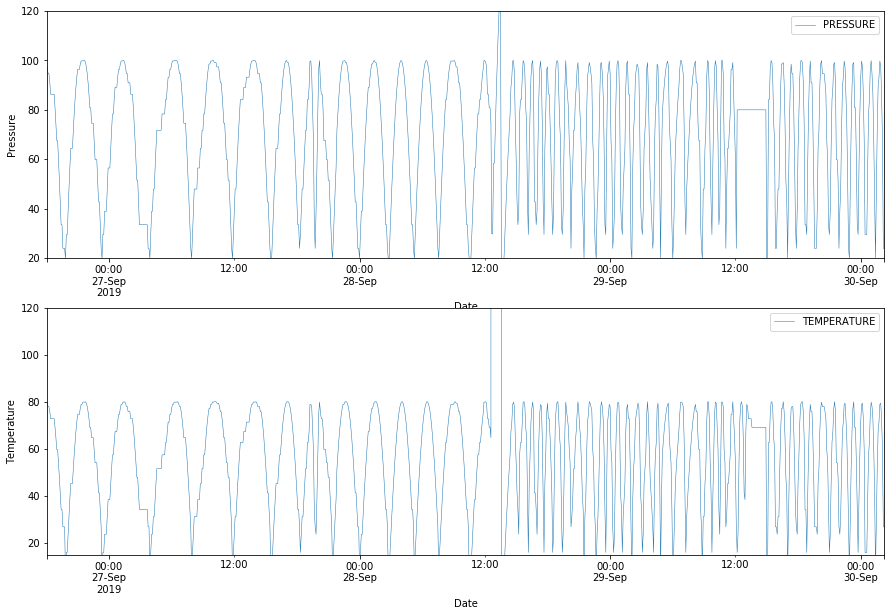

In [257]:
#df_temp = df_input[(df_input.DEVICEID == 'A101')]
#tmin = df_temp.head(1).EVT_TIMESTAMP.astype(np.int64)
#tmax = df_temp.tail(1).EVT_TIMESTAMP.astype(np.int64)
#tdiff = np.subtract(tmax, tmin) // 300000000000  # from nanosec to 5 min steps


fig, ax = plt.subplots(2, 1, figsize=(15, 10))
#df_temp.plot(ax=ax[0], lw=.5, x='EVT_TIMESTAMP', y='PRESSURE')
df_temp.plot(ax=ax[0], lw=.5, y='PRESSURE')
ax[0].set_ylim(20, 120)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Pressure')
#df_temp.plot(ax=ax[1], lw=.5, x='EVT_TIMESTAMP', y='TEMPERATURE')
df_temp.plot(ax=ax[1], lw=.5, y='TEMPERATURE')
ax[1].set_ylim(15, 120)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Temperature')

In [268]:
# Fourier transform
temp_fft = sp.fftpack.fft2(df_temp[['PRESSURE','TEMPERATURE']])
# Spectral density (energy per frequency)
temp_psd = np.abs(temp_fft) ** 2
# return sample frequencies - roughly every 5 mins
frame_rate = 1 / 288  # Hz = fft_freq * frame_rate
fftfreq = sp.fftpack.fftfreq(len(temp_psd), frame_rate)
i = fftfreq > 0

Text(0, 0.5, 'PSD (dB)')

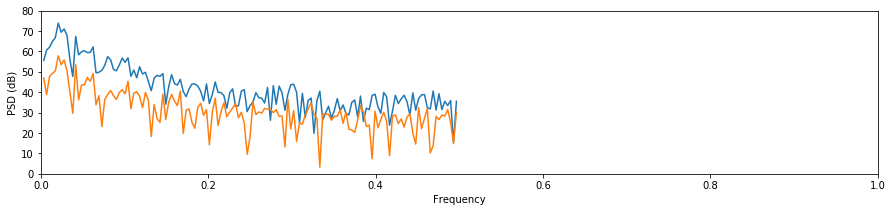

In [349]:
fig, ax = plt.subplots(1, 1, figsize=(15,3))
ax.plot(fftfreq[i] * frame_rate, 10 * np.log10(temp_psd[i]))
#ax.plot(fftfreq[i] * frame_rate, temp_psd[i])
ax.set_xlim(0, 1)
ax.set_ylim(0, 80)
ax.set_xlabel('Frequency')
ax.set_ylabel('PSD (dB)')


In [259]:
df_temp['2019-09-27 18'].head(5)

,PRESSURE,TEMPERATURE
EVT_TIMESTAMP,,
2019-09-27 18:00:00,42.737988,41.240110
2019-09-27 18:05:00,33.498815,34.190390
2019-09-27 18:10:00,33.498815,34.190390
2019-09-27 18:15:00,23.924933,26.799052
2019-09-27 18:20:00,29.552021,15.893546


In [285]:
# Fourier transform
temp_fft = sp.fftpack.fft2(df_temp['2019-9-27'])
# Spectral density (energy per frequency)
temp_psd = np.abs(temp_fft) ** 2
# return sample frequencies - roughly every 5 mins
frame_rate = 1 / 288  # Hz = fft_freq * frame_rate
fftfreq = sp.fftpack.fftfreq(len(temp_psd), frame_rate)
i = fftfreq > 0

Text(0, 0.5, 'PSD (dB)')

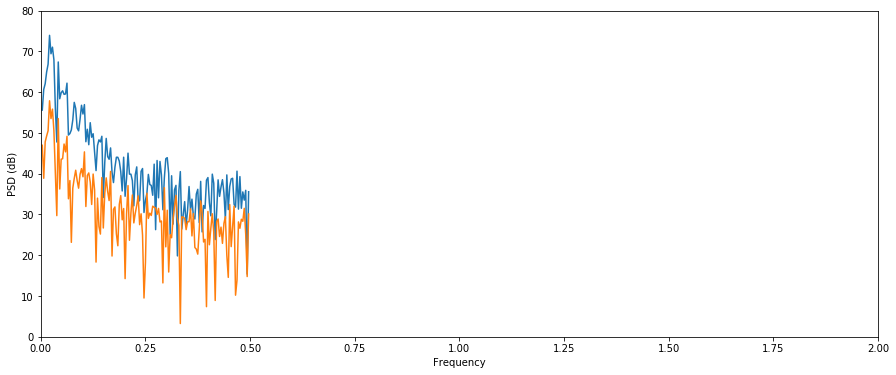

In [350]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(fftfreq[i] * frame_rate, 10 * np.log10(temp_psd[i]))
#ax.plot(fftfreq[i] * frame_rate, temp_psd[i])
ax.set_xlim(0, 2)
ax.set_ylim(0, 80)
ax.set_xlabel('Frequency')
ax.set_ylabel('PSD (dB)')

Text(0, 0.5, 'D Temperature')

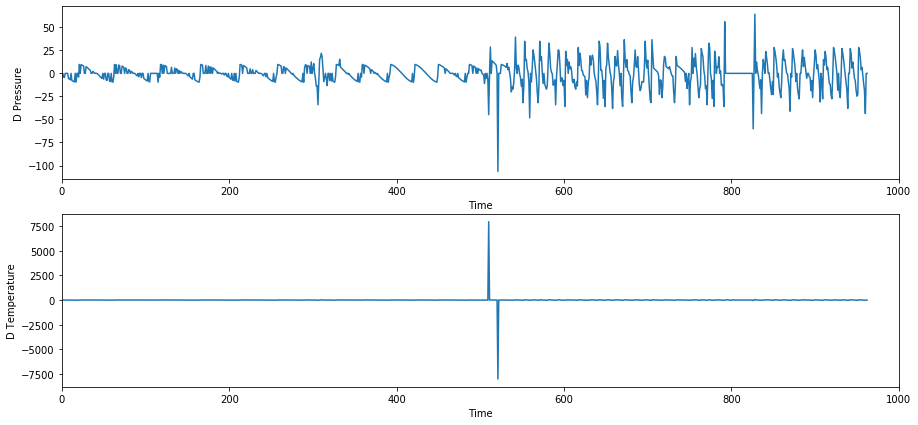

In [284]:
# look at the first discrete derivate (time)
temp_dvp = np.append(np.diff(df_temp['PRESSURE']),0)
temp_dvt = np.append(np.diff(df_temp['TEMPERATURE']),0)
temp_dt = df_temp.index.values.astype(np.int64)//300000000000 - 5231737

fig, ax = plt.subplots(2, 1, figsize=(15,7))
ax[0].plot(temp_dt, temp_dvp)
ax[0].set_xlim(0, 1000)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('D Pressure')
ax[1].plot(temp_dt, temp_dvt)
ax[1].set_xlim(0, 1000)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('D Temperature')

In [330]:
from pyod.models.knn import KNN
knn = KNN()
pred = knn.fit_predict(temp_dvt.reshape(-1,1))


/home/markus/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fit_predict is deprecated
  """Decorate function fun"""


In [352]:
import itertools
l_dvt = temp_dvt
for l,p in zip(l_dvt,pred):
    if p ==0:
        l = 0
print (pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Text(0, 0.5, 'Temperature')

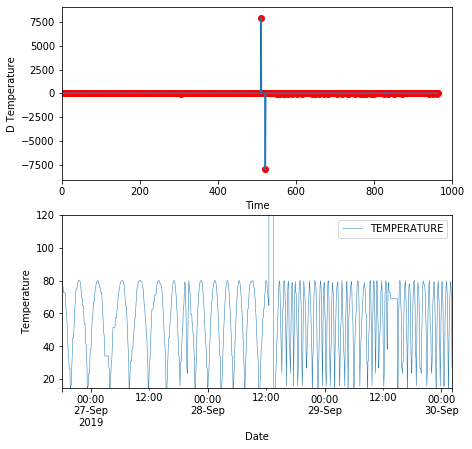

In [351]:

fig, ax = plt.subplots(2, 1, figsize=(7,7))
ax[0].plot(temp_dt, temp_dvt)
ax[0].scatter(temp_dt, l_dvt, color = 'red')

ax[0].set_xlim(0, 1000)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('D Temperature')

df_temp.plot(ax=ax[1], lw=.5, y='TEMPERATURE')
ax[1].set_ylim(15, 120)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Temperature')

In [143]:
import tslearn
0from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak
from tslearn.datasets import CachedDatasets
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset
from tslearn.generators import random_walks

a = dataset[['Val']].values.T[0] #.reshape(1,-1,1)
input = np.append(a, [73, 73, 73, 73])

if False:
  input = np.append(input,[73])
  input = np.append(input, a)
  input = np.append(input, [73,73,73])
  input = np.append(input,[73,73])
  input = np.append(input, a)
  input = np.append(input, [73,73])
  input = np.append(input,[73,73,73])
  input = np.append(input, a)
  input = np.append(input, [73])

input = input.reshape(4,-1,1)

#input.reshape(32,-1,1)
#input[1] = dataset[['Val']].values.T[0]
ts = tslearn.utils.check_dims(input[:,:,:])
#input = np.expand_dims(input, axis=1)
#ts = to_time_series(input)
#print (ts)
# all data is training data
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(ts)
ks = KShape(n_clusters=3, n_init=13, verbose=True, random_state=0).fit(X_train)
#gak_km = GlobalAlignmentKernelKMeans(n_clusters=3, sigma=sigma_gak(X_train), n_init=20,verbose=True, random_state=3452)

#y_pred = ks.fit_predict(X_train)
#ks.cluster_centers_.shape
#X = random_walks(n_ts=2396, sz=1, d=1)
ts.shape

NameError: name 'dataset' is not defined

In [160]:
ks.cluster_centers_.shape

(3, 31, 1)

Init 1
0.265 --> 0.268 --> 
Init 2
0.260 --> 0.268 --> 
Init 3
0.240 --> 0.227 --> 0.220 --> 0.220 --> 0.216 --> 0.217 --> 
Init 4
Resumed because of empty cluster
Init 4
0.251 --> 0.232 --> 0.229 --> 0.226 --> 0.223 --> 0.225 --> 
Init 5
0.249 --> 0.230 --> 0.226 --> 0.223 --> 0.217 --> 0.215 --> 0.215 --> 
Init 6
Resumed because of empty cluster
Init 6
Resumed because of empty cluster
Init 6
0.260 --> 0.260 --> 
Init 7
Resumed because of empty cluster
Init 7
0.256 --> 0.246 --> 0.245 --> 0.246 --> 
Init 8
0.293 --> 0.279 --> 0.268 --> 0.250 --> 0.231 --> 0.231 --> 
Init 9
0.241 --> 0.224 --> 0.223 --> 0.241 --> 
Init 10
Resumed because of empty cluster
Init 10
0.266 --> 0.240 --> 0.223 --> 0.216 --> 0.211 --> 0.213 --> 
Init 11
0.251 --> 0.238 --> 0.231 --> 0.234 --> 


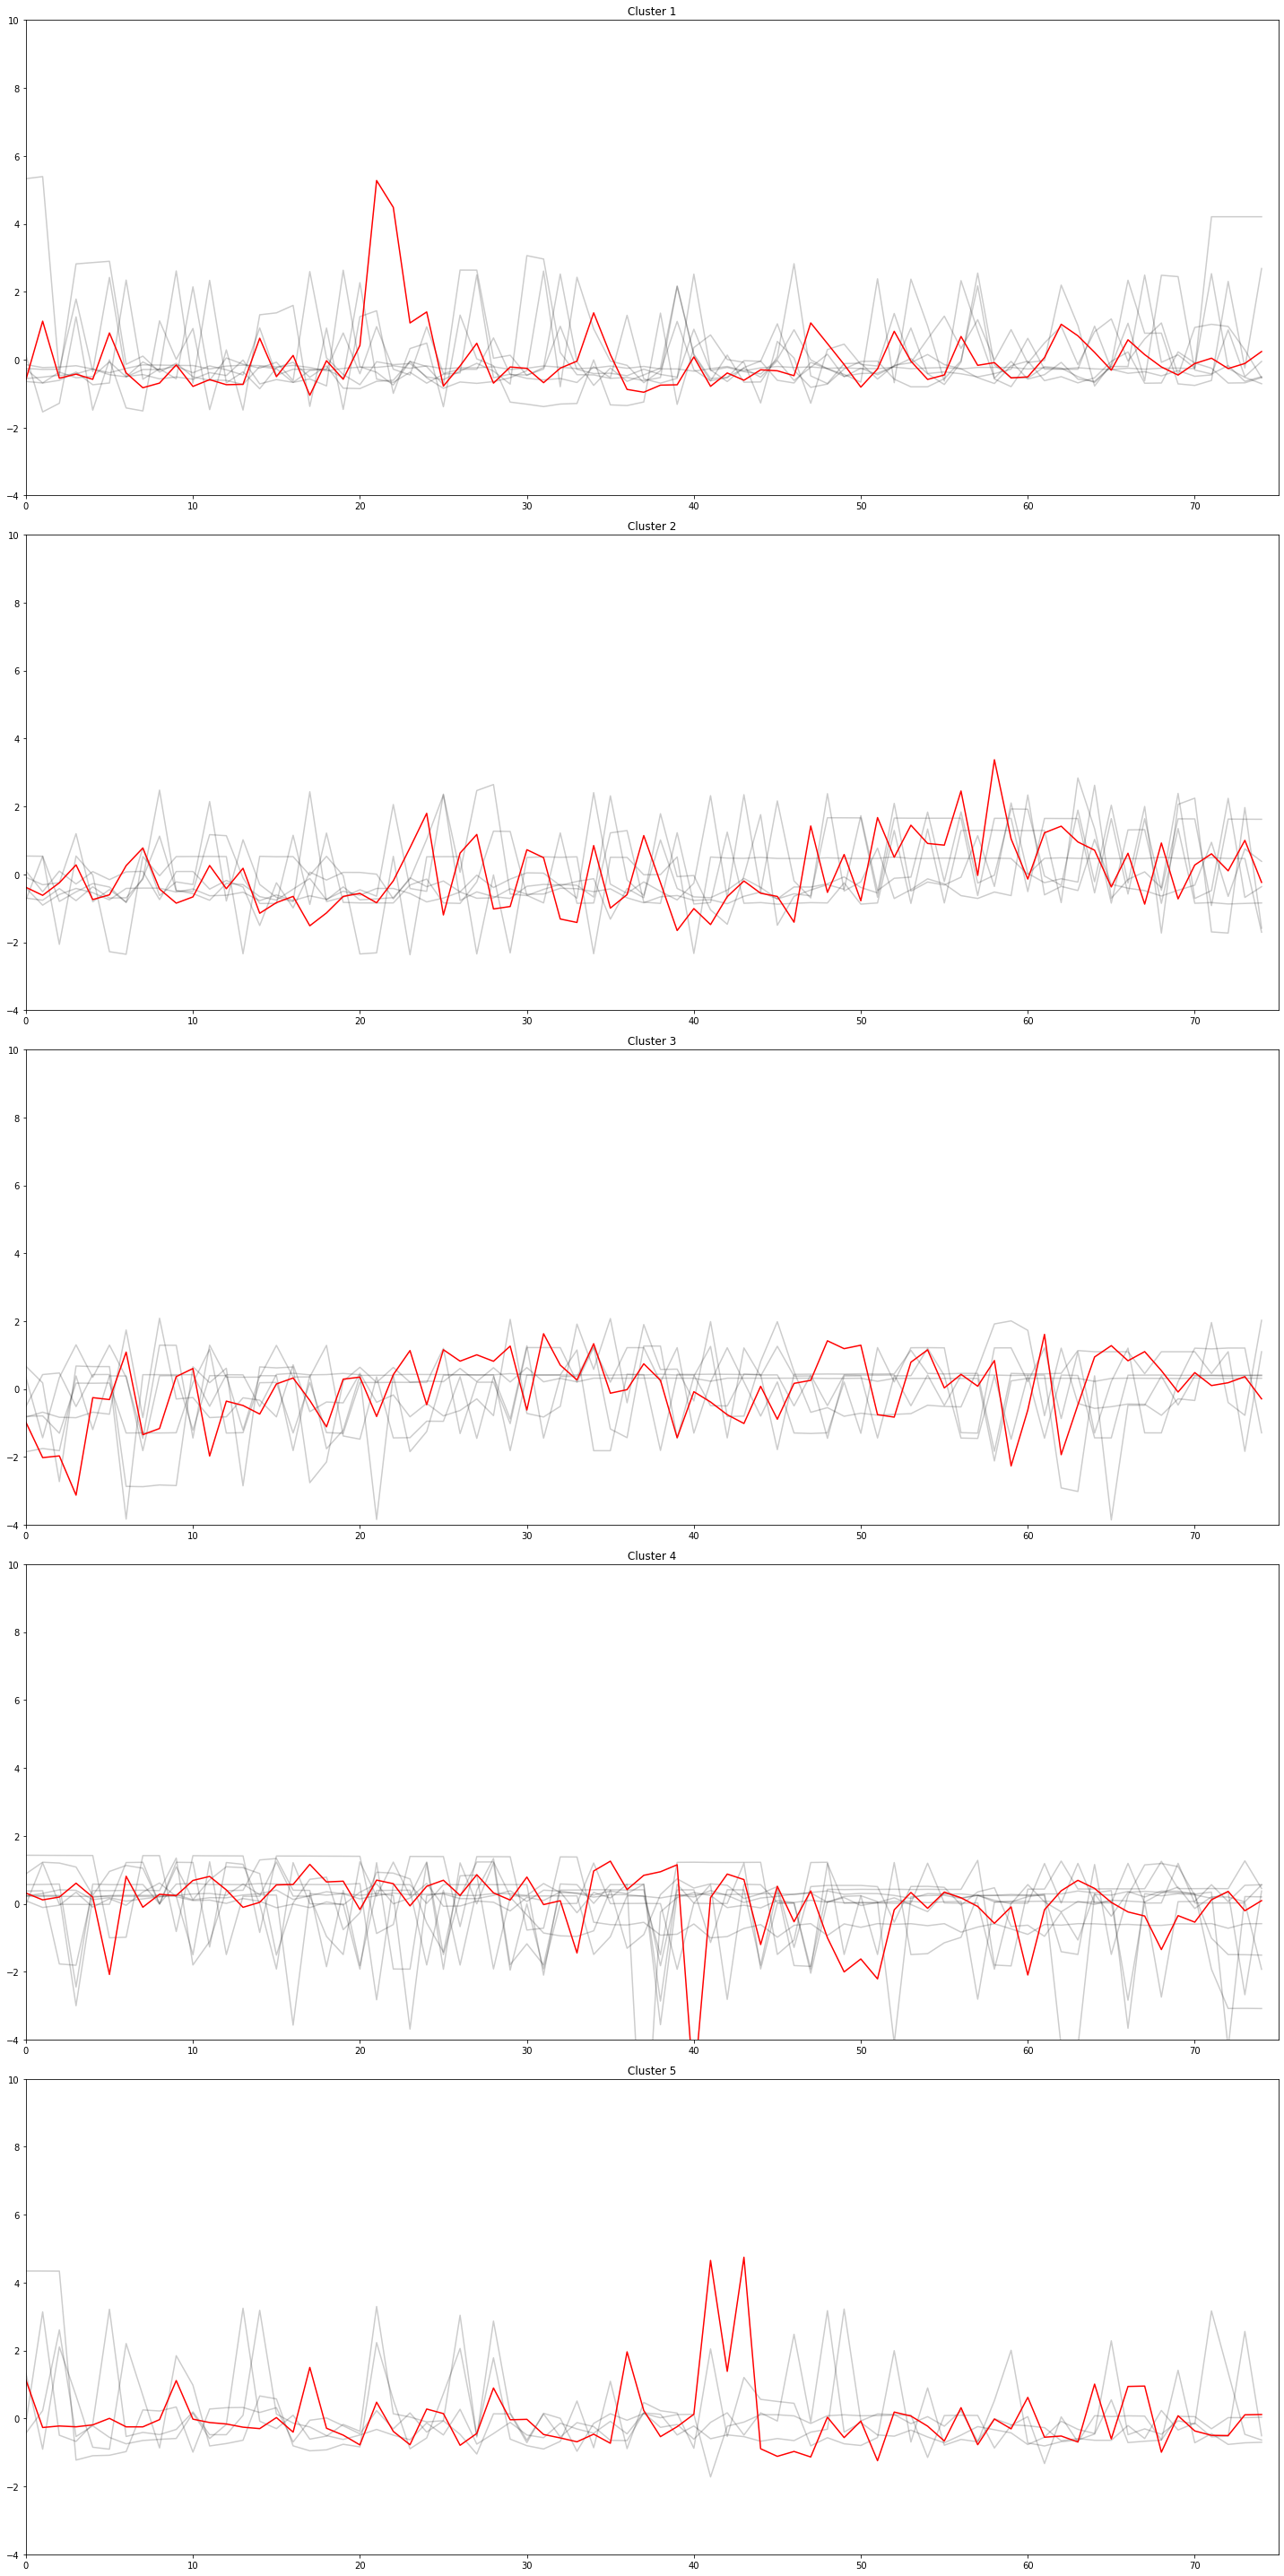

In [147]:
sz = X_train.shape[1]
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(20,40))
for yi in range(5):
    plt.subplot(5, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        #plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 10)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [148]:
print (y_pred)

[4 3 1 3 1 1 2 3 3 2 3 2 2 1 3 2 3 3 3 0 4 0 0 4 1 0 0 2 1 4 0 0]
